In [1]:
import pandas as pd
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
from scripts.backtesting.backtesting import Strategy, Backtest 
from scripts.backtesting.lib import resample_apply
from ta.trend import EMAIndicator
import scripts.functions as fn 


c:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www\backtest


c:\Users\lbisa\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'
klines_file = './backtest/klines/0m01/Bajista_BNBUSDT_0m01_2021-04-12_2021-07-12.DataFrame'

with open(klines_file, 'rb') as file:
    data = pickle.load(file)

start_date = klines_file.split('/')[4].split('_')[3] #Extrae la fecha de inicio
start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
start_date = pd.to_datetime('2021-05-21', format='%Y-%m-%d')
start_date = start_date.replace(hour=0, minute=0, second=0)

data.set_index('datetime',inplace=True)
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

data['ma'] = data['Close'].rolling(window=21).mean()
data['compra'] = (data['Close'] < data['ma']) 
data['venta']  = (data['Close'] > data['ma']) 
data['signal'] = np.where(data['compra'], 'COMPRA', 'NEUTRO')
data['signal'] = np.where(data['venta'], 'VENTA',data['signal'])
data.drop('ma', axis=1, inplace=True)
data.drop('compra', axis=1, inplace=True)
data.drop('venta', axis=1, inplace=True)

data = data[data.index>=start_date]



In [3]:


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 7
    n2 = 30
    sl = 1
    tp = 10

    orderid = 0

    buy_price = 0
    signal = 'NEUTRO'
    
    def init(self):
        super().init()

       
        
    def next(self):
        if self.signal == 'COMPRA' and self._broker._cash > 10 and self._broker.position.size == 0: 
            price = self._broker.last_price
            size = (self._broker._cash * 0.8) / price
            self.buy(size=size)
                 
        if self.signal == 'VENTA' and self._broker.position.size > 0: 
            self.position.close()  

        
        self.signal = self.data.signal[-1]

In [4]:
#Quita las primeras 210 velas, que son agregadas al descargar datos para preveer el armado de indicadores 
#y que la estrategia inicie con los indicadores previamente armados 


class Bot(Backtest):
    
    def __init__(self,data,strategy):
        #Ajusa el precio a valores entre referenciales porque Backtesting.py limita los decimales en el size para las compras
        cash = 100000

        super().__init__(data, strategy, cash=cash, commission=.002, trade_on_close=False)
    
bot = Bot(data,SmaCross)
stats = bot.run()

bot.plot(open_browser=True, plot_trades=False, resample=True, superimpose='1W')


GridPlot(id='p1423', ...)

In [5]:

print(f'Periodo: {stats.Start} al {stats.End}')
print(f'Duracion: {stats.Duration}')
print('Return (Ann.) [%]',stats['Return (Ann.) [%]'])
print('Max. Drawdown [%]',stats['Max. Drawdown [%]'])
print('# Trades',stats['# Trades'])
#stats


Periodo: 2021-05-21 00:00:00 al 2021-07-12 23:59:00
Duracion: 52 days 23:59:00
Return (Ann.) [%] 1551.578774835616
Max. Drawdown [%] -26.862319806286916
# Trades 6280


In [6]:
#bot.plot(open_browser=True,resample=True,superimpose='1D')
equity = stats._equity_curve.copy()
# 
print(equity.head())
print(data[209:].head())

                            Equity  DrawdownPct DrawdownDuration
2021-05-21 00:00:00  100000.000000     0.000000              NaT
2021-05-21 00:01:00  100000.000000     0.000000              NaT
2021-05-21 00:02:00  100000.000000     0.000000              NaT
2021-05-21 00:03:00   99699.959726     0.003000              NaT
2021-05-21 00:04:00   99482.480870     0.005175              NaT
                       Open    High     Low   Close     Volume signal
2021-05-21 03:29:00  383.90  383.97  381.69  381.81  5300.5704  VENTA
2021-05-21 03:30:00  381.78  384.40  381.76  384.34  2207.7346  VENTA
2021-05-21 03:31:00  384.34  385.16  384.32  385.07  2583.4851  VENTA
2021-05-21 03:32:00  385.14  385.29  384.32  385.29  1538.4106  VENTA
2021-05-21 03:33:00  385.27  386.92  384.85  385.83  2699.6065  VENTA


<Axes: >

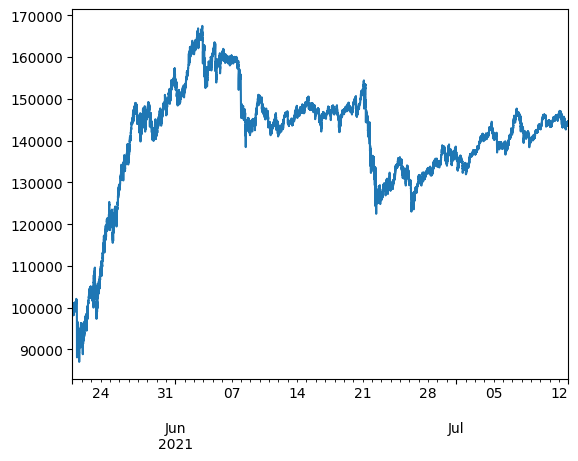

In [7]:
equity['Equity'].plot()


